In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install psycopg2
!pip install python-dotenv
!pip install sqlalchemy

In [82]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import psycopg2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Extraction

## Loading Env Variables

In [85]:
# Env variables
dotenv_path = './.env'
load_dotenv(dotenv_path)

dbname = os.getenv('DB_NAME')
user = os.getenv('DB_USER')
password = os.getenv('DB_PASS')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

## Connect to DB

In [86]:
db_url = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

# Create an SQLAlchemy engine
engine = create_engine(db_url)

## Creating Dataframes


In [87]:
# Define SQL queries
get_fact_table = "SELECT * FROM flights_fact_table"
get_date_dimension = "SELECT * FROM date_dimension"
get_location_dimension = "SELECT * FROM location_dimension"
get_aircraft_dimension = "SELECT * FROM aircraft_dimension"

# Execute the SQL query and fetch the data
flights_fact_table = pd.read_sql(get_fact_table, engine)
date_dimension = pd.read_sql(get_date_dimension, engine)
aircraft_dimension = pd.read_sql(get_aircraft_dimension, engine)
location_dimension = pd.read_sql(get_location_dimension, engine)

display(flights_fact_table)
display(date_dimension)
display(aircraft_dimension)
display(location_dimension)


print("Fact Table Data Types:\n")
print(flights_fact_table.dtypes)

print("Date Dimension Data Types:\n")
print(date_dimension.dtypes)

print("Aircraft Dimension Data Types:\n")
print(aircraft_dimension.dtypes)

print("Location Dimension Data Types:\n")
print(location_dimension.dtypes)

,Date_Key,Aircraft_Key,Origin_Key,Dest_Key,FlightNum,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,...,TaxiIn,TaxiOut,ActualElapsedTime,CRSElapsedTime,AirTime,DepTime,CRSDepTime,ArrTime,CRSArrTime,TotalDelayTime
0,1,212,49,36,2934,588,11.0,0.0,0.0,0.0,...,4.0,10.0,118.0,120.0,104.0,09:42:00,09:25:00,10:40:00,10:25:00,32.0
1,1,2653,81,221,851,602,25.0,0.0,11.0,0.0,...,4.0,11.0,106.0,117.0,91.0,09:07:00,08:20:00,10:53:00,10:17:00,83.0
2,1,2653,221,81,424,602,0.0,0.0,19.0,0.0,...,8.0,25.0,118.0,106.0,85.0,11:29:00,10:57:00,13:27:00,12:43:00,76.0
3,1,2653,81,156,775,629,14.0,0.0,3.0,0.0,...,10.0,8.0,115.0,114.0,97.0,14:21:00,14:05:00,15:16:00,14:59:00,33.0
4,1,2653,156,81,770,629,3.0,0.0,17.0,0.0,...,7.0,19.0,113.0,110.0,87.0,15:59:00,15:40:00,18:52:00,18:30:00,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247481,366,1232,260,237,5482,199,0.0,0.0,0.0,0.0,...,5.0,15.0,65.0,65.0,45.0,14:26:00,13:30:00,15:31:00,14:35:00,112.0
1247482,366,1839,97,64,687,529,13.0,0.0,0.0,0.0,...,8.0,20.0,110.0,126.0,82.0,18:09:00,17:10:00,19:59:00,19:16:00,102.0
1247483,366,1886,88,64,1682,500,14.0,0.0,1.0,0.0,...,6.0,15.0,102.0,101.0,81.0,19:17:00,19:00:00,20:59:00,20:41:00,35.0
1247484,366,1972,64,289,1851,1735,10.0,0.0,10.0,0.0,...,4.0,27.0,276.0,266.0,245.0,20:23:00,20:10:00,22:59:00,22:36:00,36.0


,Date_Key,Year,Month,DayofMonth,DayOfWeek
0,1,2008,1,1,2
1,2,2008,1,2,3
2,3,2008,1,3,4
3,4,2008,1,4,5
4,5,2008,1,5,6
...,...,...,...,...,...
361,362,2008,12,27,6
362,363,2008,12,28,7
363,364,2008,12,29,1
364,365,2008,12,30,2


,Aircraft_Key,UniqueCarrier,TailNum
0,1,WN,N464WN
1,2,WN,N763SW
2,3,WN,N334SW
3,4,WN,N286WN
4,5,WN,N674AA
...,...,...,...
5346,5347,B6,N763JB
5347,5348,B6,N766JB
5348,5349,CO,N75428
5349,5350,CO,N75429


,Location_Key,Airport_Code
0,1,ABE
1,2,ABI
2,3,ABQ
3,4,ABY
4,5,ACK
...,...,...
297,298,WYS
298,299,XNA
299,300,YAK
300,301,YKM


Fact Table Data Types:

Date_Key               int64
Aircraft_Key           int64
Origin_Key             int64
Dest_Key               int64
FlightNum             object
Distance               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
ArrDelay             float64
DepDelay             float64
TaxiIn               float64
TaxiOut              float64
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
DepTime               object
CRSDepTime            object
ArrTime               object
CRSArrTime            object
TotalDelayTime       float64
dtype: object
Date Dimension Data Types:

Date_Key      int64
Year          int64
Month         int64
DayofMonth    int64
DayOfWeek     int64
dtype: object
Aircraft Dimension Data Types:

Aircraft_Key      int64
UniqueCarrier    object
TailNum          object
dtype: object
Location Dimension Data Types:

Loc

# Step 2: Data Summarization

## Data Summarization - Fact Table

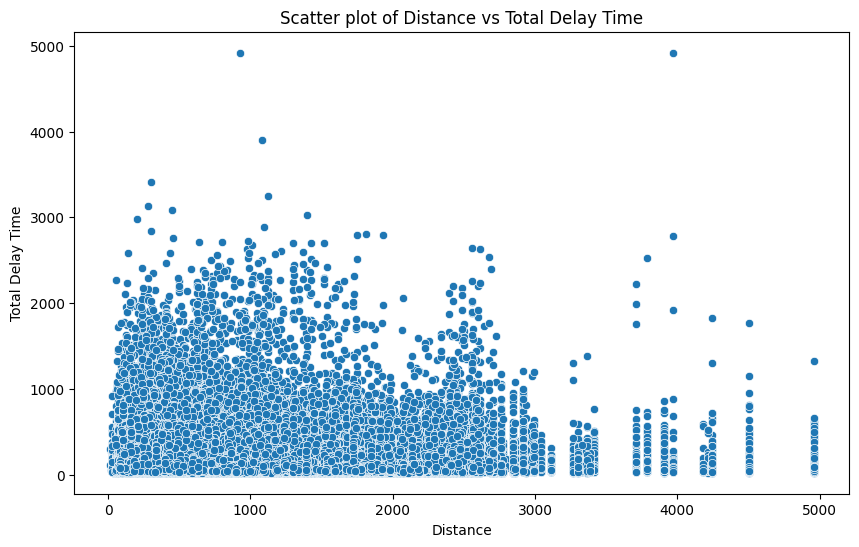

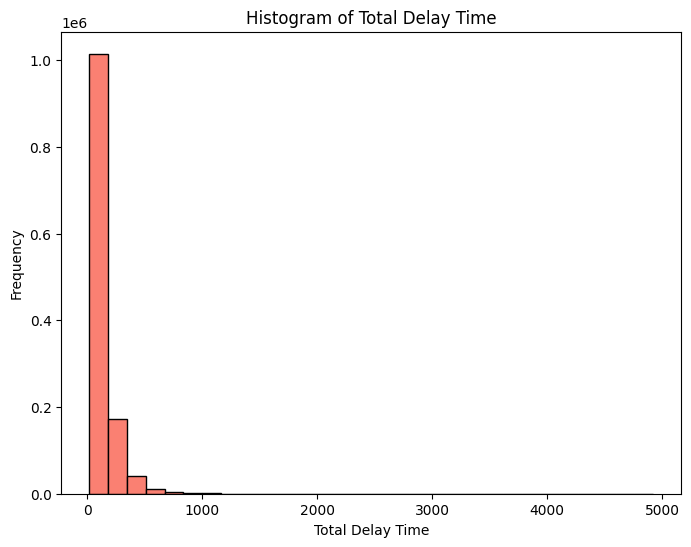

In [88]:
# Scatter plot to visualize the relationship between Distance and Total Delay Time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Distance', y='TotalDelayTime', data=flights_fact_table)
plt.title('Scatter plot of Distance vs Total Delay Time')
plt.xlabel('Distance')
plt.ylabel('Total Delay Time')
plt.show()

# Histogram of Total Delay Time
plt.figure(figsize=(8, 6))
plt.hist(flights_fact_table['TotalDelayTime'], bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Total Delay Time')
plt.xlabel('Total Delay Time')
plt.ylabel('Frequency')
plt.show()

## Data Summarization - Aircraft Dimension

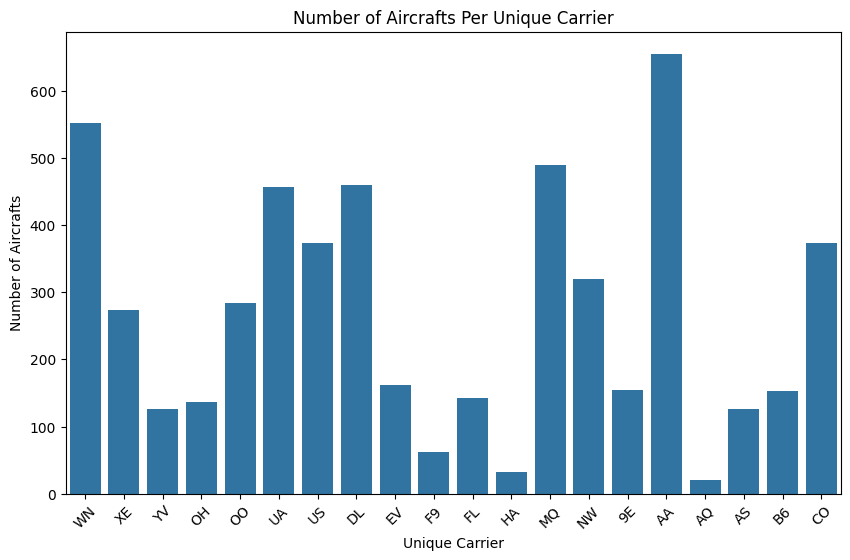

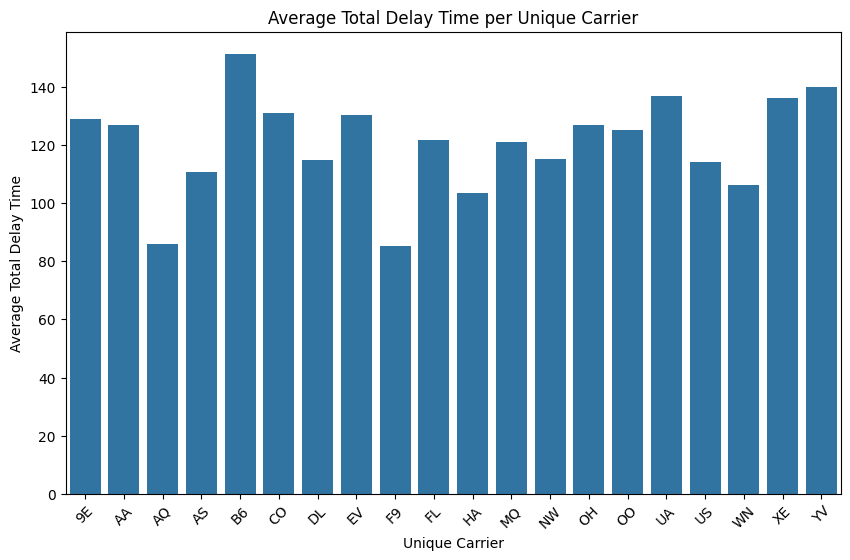

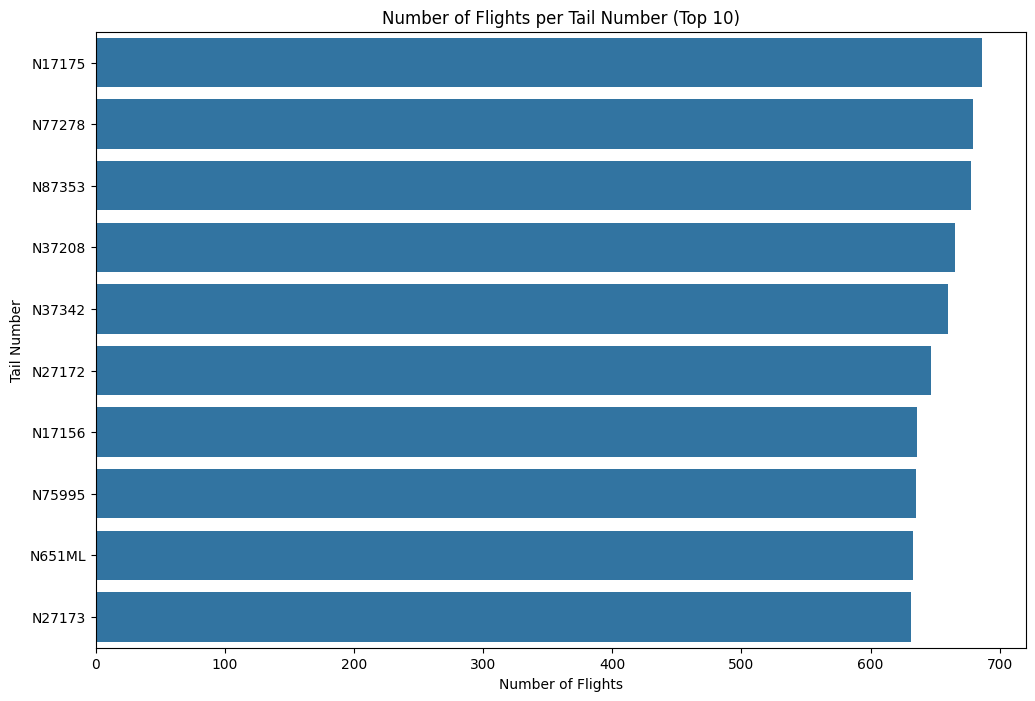

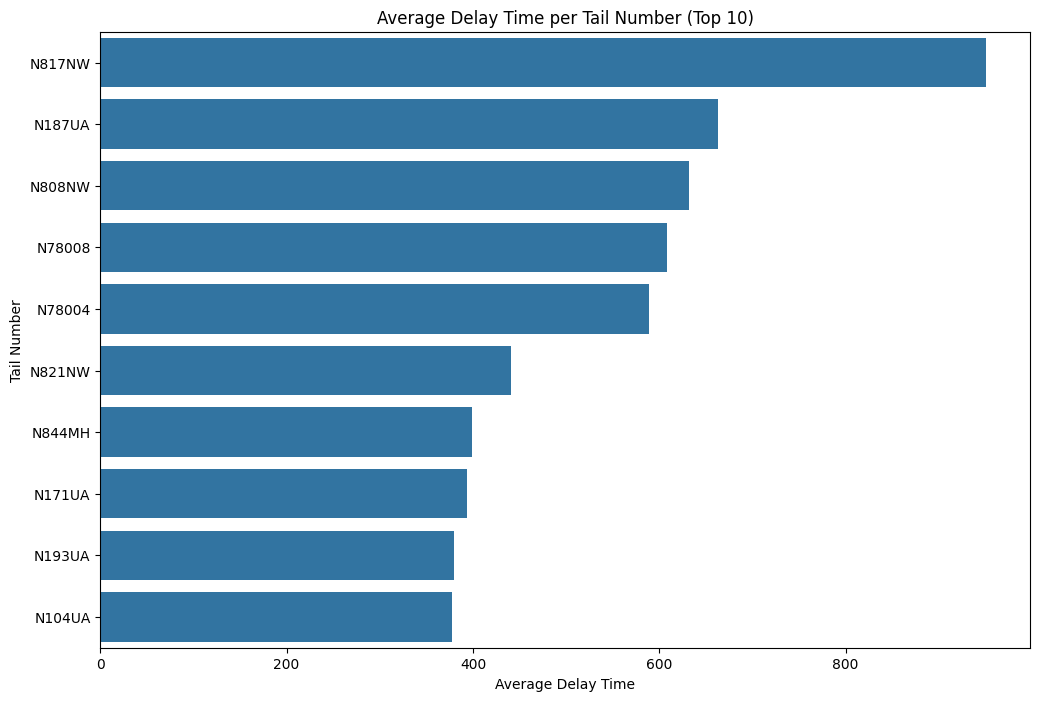

In [89]:
# Bar plot of Aircrafts per Unique Carrier
plt.figure(figsize=(10, 6))
sns.countplot(x='UniqueCarrier', data=aircraft_dimension)
plt.title('Number of Aircrafts Per Unique Carrier')
plt.xlabel('Unique Carrier')
plt.ylabel('Number of Aircrafts')
plt.xticks(rotation=45)
plt.show()

# Average total delay time per unique carrier
merged_data_carrier = pd.merge(flights_fact_table, aircraft_dimension, how='left', left_on='Aircraft_Key', right_on='Aircraft_Key')
average_delay_per_carrier = merged_data_carrier.groupby('UniqueCarrier')['TotalDelayTime'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='UniqueCarrier', y='TotalDelayTime', data=average_delay_per_carrier)
plt.title('Average Total Delay Time per Unique Carrier')
plt.xlabel('Unique Carrier')
plt.ylabel('Average Total Delay Time')
plt.xticks(rotation=45)
plt.show()

# Number of flights per TailNum
merged_data_tailnum = pd.merge(flights_fact_table, aircraft_dimension, how='left', on='Aircraft_Key')
plt.figure(figsize=(12, 8))
sns.countplot(y='TailNum', data=merged_data_tailnum, order=merged_data_tailnum['TailNum'].value_counts().index[:10])
plt.title('Number of Flights per Tail Number (Top 10)')
plt.xlabel('Number of Flights')
plt.ylabel('Tail Number')
plt.show()

# Average total delay time per TailNum
merged_data_tailnum = pd.merge(flights_fact_table, aircraft_dimension, how='left', left_on='Aircraft_Key', right_on='Aircraft_Key')
avg_delay_per_tailnum = merged_data_tailnum.groupby('TailNum')['TotalDelayTime'].mean().reset_index(name='AverageDelay')
avg_delay_per_tailnum = avg_delay_per_tailnum.sort_values(by='AverageDelay', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='AverageDelay', y='TailNum', data=avg_delay_per_tailnum.head(10))
plt.title('Average Delay Time per Tail Number (Top 10)')
plt.xlabel('Average Delay Time')
plt.ylabel('Tail Number')
plt.show()

## Data Summarization - Date Dimension

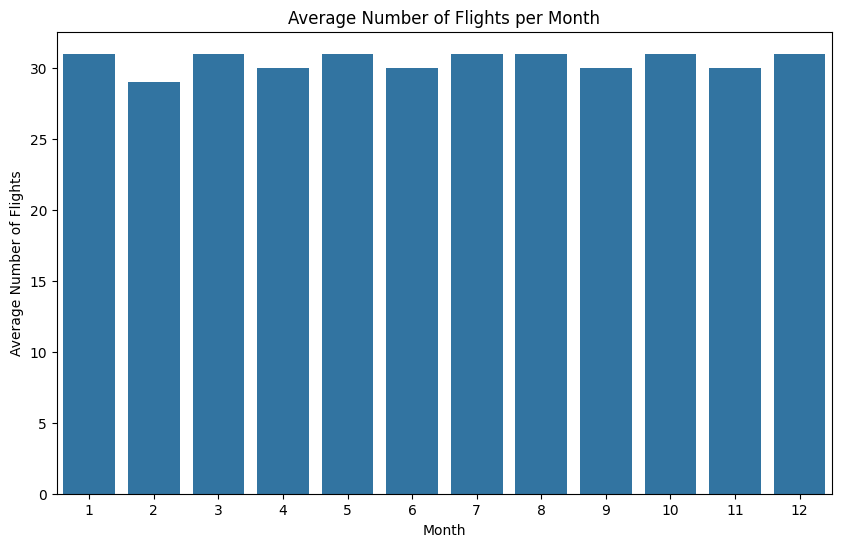

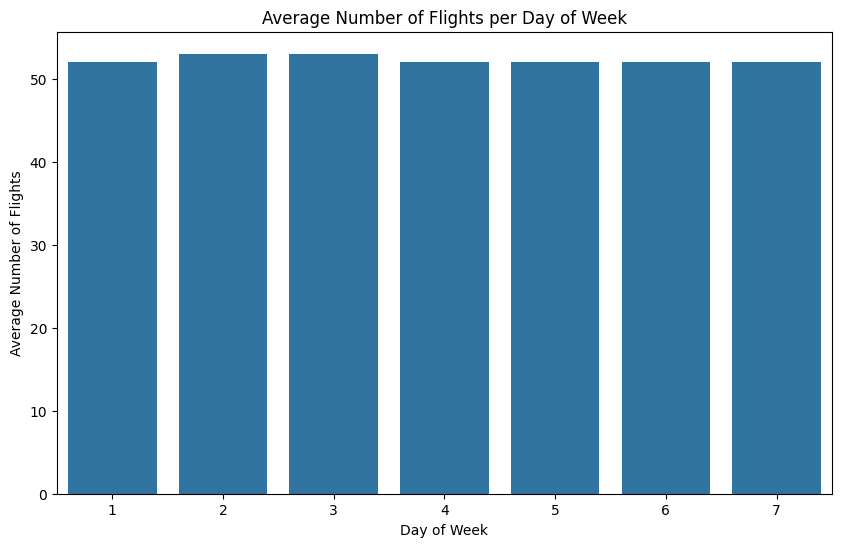

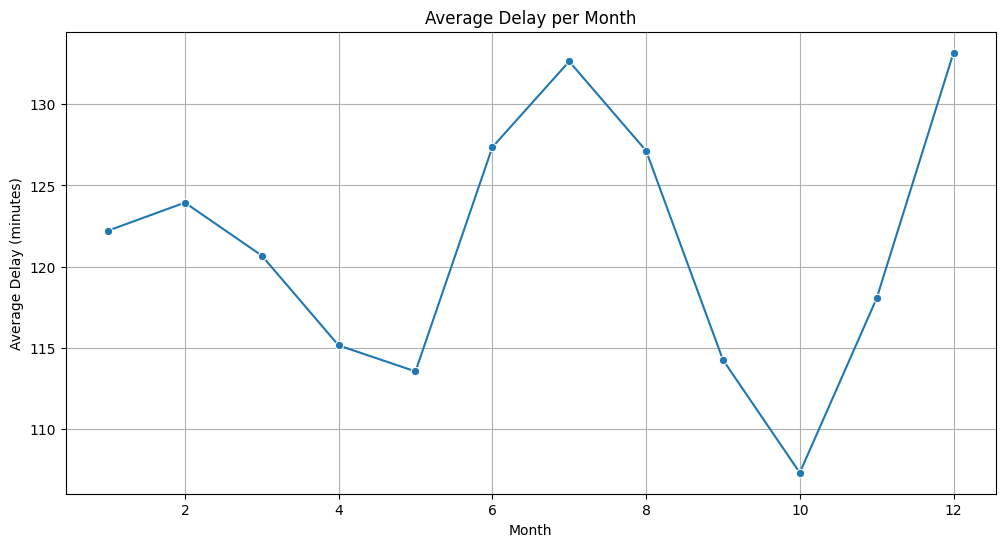

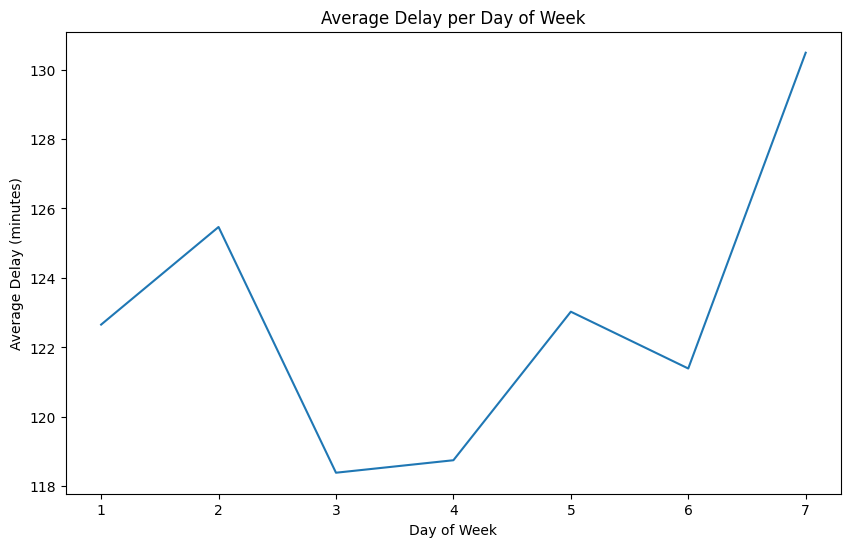

In [90]:
# Average number of flights per month
average_flights_per_month = date_dimension.groupby('Month').size().reset_index(name='AverageFlights')
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='AverageFlights', data=average_flights_per_month)
plt.title('Average Number of Flights per Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Flights')
plt.show()

# Average number of flights per day of week
average_flights_per_dayofweek = date_dimension.groupby('DayOfWeek').size().reset_index(name='AverageFlights')
plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeek', y='AverageFlights', data=average_flights_per_dayofweek)
plt.title('Average Number of Flights per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Flights')
plt.show()

# Average delay per month
merged_data_month = pd.merge(flights_fact_table, date_dimension, how='left', on='Date_Key')
average_delay_per_month = merged_data_month.groupby('Month')['TotalDelayTime'].mean().reset_index(name='AverageDelay')
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='AverageDelay', data=average_delay_per_month, marker='o')
plt.title('Average Delay per Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

# Average delay per day of week
merged_data = pd.merge(flights_fact_table, date_dimension, how='left', on='Date_Key')
average_delay_per_dayofweek = merged_data.groupby('DayOfWeek')['TotalDelayTime'].mean().reset_index(name='AverageDelay')
plt.figure(figsize=(10, 6))
sns.lineplot(x='DayOfWeek', y='AverageDelay', data=average_delay_per_dayofweek)
plt.title('Average Delay per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Delay (minutes)')
plt.show()

## Data Summarization - Location Dimension

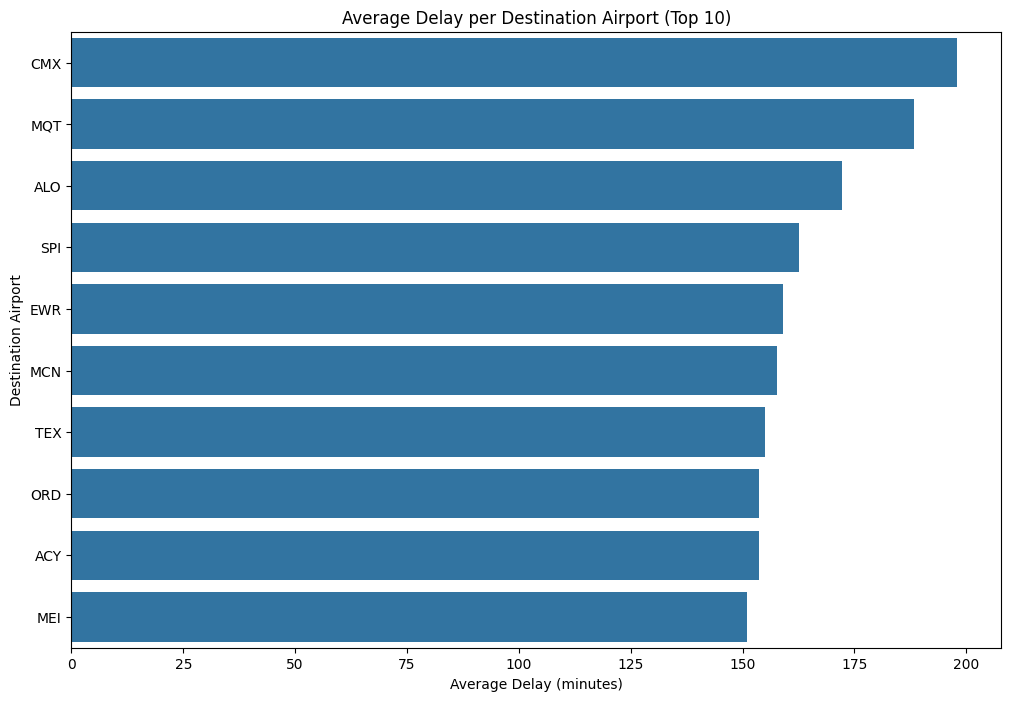

In [91]:
# Average Delay Time per Destination Airport
merged_data_destination = pd.merge(flights_fact_table, location_dimension, how='left', left_on='Dest_Key', right_on='Location_Key')
average_delay_per_destination = merged_data_destination.groupby('Airport_Code')['TotalDelayTime'].mean().reset_index(name='AverageDelay')
average_delay_per_destination = average_delay_per_destination.sort_values(by='AverageDelay', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(y='Airport_Code', x='AverageDelay', data=average_delay_per_destination.head(10))
plt.title('Average Delay per Destination Airport (Top 10)')
plt.xlabel('Average Delay (minutes)')
plt.ylabel('Destination Airport')
plt.show()

# Handling Missing Values

## Gathering Initial Data About Null Values

In [92]:
total_nulls_fact_table = flights_fact_table.isnull().sum()
total_nulls_location_dimension = location_dimension.isnull().sum()
total_nulls_date_dimension = date_dimension.isnull().sum()
total_nulls_aircraft_dimension = aircraft_dimension.isnull().sum()

print("Null records per column fact table:")
print(total_nulls_fact_table, "\n")

print("Null records per column location dimension:")
print(total_nulls_location_dimension, "\n")

print("Null records per column date dimension:")
print(total_nulls_date_dimension, "\n")

print("Null records per column aircraft dimension:")
print(total_nulls_aircraft_dimension)

Null records per column fact table:
Date_Key             0
Aircraft_Key         0
Origin_Key           0
Dest_Key             0
FlightNum            0
Distance             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
ArrDelay             0
DepDelay             0
TaxiIn               0
TaxiOut              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
TotalDelayTime       0
dtype: int64 

Null records per column location dimension:
Location_Key    0
Airport_Code    0
dtype: int64 

Null records per column date dimension:
Date_Key      0
Year          0
Month         0
DayofMonth    0
DayOfWeek     0
dtype: int64 

Null records per column aircraft dimension:
Aircraft_Key     0
UniqueCarrier    0
TailNum          0
dtype: int64


No null values were found, as all were handled during the ETL phase.

# Handling categorical attributes through e.g. one-hot encoding or conversion to ordinal data

The following categorical attributes exist in the dataset:
- TailNum
- AirportCode
- UniqueCarrier

## Encoding TailNum
TailNum is already mapped directly to a primary key, thus we may simply replace each TailNum with its associated primary key.

In [93]:
aircraft_dimension['TailNum'] = aircraft_dimension['Aircraft_Key']

## Encoding AirportCode
AirportCode is already mapped directly to a primary key, thus we may simply replace each AirportCode with its associated primary key.

In [94]:
location_dimension['Airport_Code'] = location_dimension['Location_Key']

## Encoding UniqueCarrier
UniqueCarrier does not have an associated primary key. Therefore, it will be encoded as an integer.



In [95]:
from sklearn.preprocessing import LabelEncoder

unique_carrier_data = aircraft_dimension['UniqueCarrier']
label_encoder = LabelEncoder()
unique_carrier_encoded = label_encoder.fit_transform(unique_carrier_data)
aircraft_dimension['UniqueCarrier'] = unique_carrier_encoded

print("Aircraft Dimension with Unique Carrier Encoded:\n")
print(aircraft_dimension)


Aircraft Dimension with Unique Carrier Encoded:

      Aircraft_Key  UniqueCarrier  TailNum
0                1             17        1
1                2             17        2
2                3             17        3
3                4             17        4
4                5             17        5
...            ...            ...      ...
5346          5347              4     5347
5347          5348              4     5348
5348          5349              5     5349
5349          5350              5     5350
5350          5351              5     5351

[5351 rows x 3 columns]


## Converting Time Fields to Numerical Data

Time fields should be converted to numerical data so that they may be handled during ML processing.

Times will be converted to minutes past midnight.

In [96]:
flights_fact_table['DepTime'] = flights_fact_table['DepTime'].apply(lambda x: x.hour * 60 + x.minute)
flights_fact_table['CRSDepTime'] = flights_fact_table['CRSDepTime'].apply(lambda x: x.hour * 60 + x.minute)
flights_fact_table['ArrTime'] = flights_fact_table['ArrTime'].apply(lambda x: x.hour * 60 + x.minute)
flights_fact_table['CRSArrTime'] = flights_fact_table['CRSArrTime'].apply(lambda x: x.hour * 60 + x.minute)

flights_fact_table


,Date_Key,Aircraft_Key,Origin_Key,Dest_Key,FlightNum,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,...,TaxiIn,TaxiOut,ActualElapsedTime,CRSElapsedTime,AirTime,DepTime,CRSDepTime,ArrTime,CRSArrTime,TotalDelayTime
0,1,212,49,36,2934,588,11.0,0.0,0.0,0.0,...,4.0,10.0,118.0,120.0,104.0,582,565,640,625,32.0
1,1,2653,81,221,851,602,25.0,0.0,11.0,0.0,...,4.0,11.0,106.0,117.0,91.0,547,500,653,617,83.0
2,1,2653,221,81,424,602,0.0,0.0,19.0,0.0,...,8.0,25.0,118.0,106.0,85.0,689,657,807,763,76.0
3,1,2653,81,156,775,629,14.0,0.0,3.0,0.0,...,10.0,8.0,115.0,114.0,97.0,861,845,916,899,33.0
4,1,2653,156,81,770,629,3.0,0.0,17.0,0.0,...,7.0,19.0,113.0,110.0,87.0,959,940,1132,1110,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247481,366,1232,260,237,5482,199,0.0,0.0,0.0,0.0,...,5.0,15.0,65.0,65.0,45.0,866,810,931,875,112.0
1247482,366,1839,97,64,687,529,13.0,0.0,0.0,0.0,...,8.0,20.0,110.0,126.0,82.0,1089,1030,1199,1156,102.0
1247483,366,1886,88,64,1682,500,14.0,0.0,1.0,0.0,...,6.0,15.0,102.0,101.0,81.0,1157,1140,1259,1241,35.0
1247484,366,1972,64,289,1851,1735,10.0,0.0,10.0,0.0,...,4.0,27.0,276.0,266.0,245.0,1223,1210,1379,1356,36.0


# Normalization of numeric attributes to ensure all attributes are of equal importance during learning

In [97]:
from sklearn.preprocessing import MinMaxScaler

numeric_attributes = flights_fact_table[['Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'TotalDelayTime']]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
scaled_numeric_attributes = scaler.fit_transform(numeric_attributes)
flights_fact_table[['Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'TotalDelayTime']] = scaled_numeric_attributes

# Calculate minimum and maximum values of each attribute after scaling
min_values = flights_fact_table[['Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'TotalDelayTime']].min()
max_values = flights_fact_table[['Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'TotalDelayTime']].max()

print("Min values after scaling:\n", min_values)
print("\nMax values after scaling:\n", max_values)

Min values after scaling:
 Distance             0.0
CarrierDelay         0.0
WeatherDelay         0.0
NASDelay             0.0
SecurityDelay        0.0
LateAircraftDelay    0.0
ArrDelay             0.0
DepDelay             0.0
TaxiIn               0.0
TaxiOut              0.0
ActualElapsedTime    0.0
CRSElapsedTime       0.0
AirTime              0.0
TotalDelayTime       0.0
dtype: float64

Max values after scaling:
 Distance             1.0
CarrierDelay         1.0
WeatherDelay         1.0
NASDelay             1.0
SecurityDelay        1.0
LateAircraftDelay    1.0
ArrDelay             1.0
DepDelay             1.0
TaxiIn               1.0
TaxiOut              1.0
ActualElapsedTime    1.0
CRSElapsedTime       1.0
AirTime              1.0
TotalDelayTime       1.0
dtype: float64


# Feature selection to remove potentially redundant attributes

Using ANOVA filtering to identify the most relevant variables or features from a dataset for an


In [98]:
from sklearn.feature_selection import SelectKBest, f_classif

merged_table = pd.merge(flights_fact_table, date_dimension, on='Date_Key')
merged_table = pd.merge(merged_table, aircraft_dimension, on='Aircraft_Key')
merged_table = pd.merge(merged_table, location_dimension, left_on='Origin_Key', right_on='Location_Key', suffixes=('_flight', '_origin'))
merged_table = pd.merge(merged_table, location_dimension, left_on='Dest_Key', right_on='Location_Key', suffixes=('_origin', '_dest'))

# Drop unnecessary keys
merged_table.drop(columns=['Date_Key', 'Aircraft_Key', 'Origin_Key', 'Dest_Key', 'Location_Key_origin', 'Location_Key_dest'], inplace=True)

# Drop features that will not be used to predict TotalDelayTime
merged_table.drop(columns=['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut'], inplace=True)

# Drop Year (since it is constant for the year 2008)
merged_table.drop(columns=['Year'], inplace=True)

# Define the feature variables and the target variable
X = merged_table.drop(columns=['TotalDelayTime'])  # All features except the target
y = merged_table['TotalDelayTime']

# Perform feature selection using ANOVA
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Get the scores and p-values for each feature
scores = selector.scores_
p_values = selector.pvalues_

# Zip feature names with their scores and p-values
feature_scores = list(zip(X.columns, scores, p_values))

# Sort feature scores based on scores (index 1 of each tuple)
sorted_feature_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Print sorted feature scores
print("Features displayed in order of importance:\n")
for feature, score, p_value in sorted_feature_scores:
    print(f"Feature: {feature}, Score: {score}, p-value: {p_value}")

Features displayed in order of importance:

Feature: DepTime, Score: 24.122921020961332, p-value: 0.0
Feature: ArrTime, Score: 9.670696400456151, p-value: 0.0
Feature: CRSDepTime, Score: 8.335586393982917, p-value: 0.0
Feature: CRSArrTime, Score: 6.656431007021602, p-value: 0.0
Feature: ActualElapsedTime, Score: 3.3633857676477916, p-value: 0.0
Feature: FlightNum, Score: 3.060951161538377, p-value: 0.0
Feature: CRSElapsedTime, Score: 2.3302494789650985, p-value: 1.4642919077799932e-192
Feature: AirTime, Score: 2.160980525377711, p-value: 9.844270741140841e-156
Feature: Distance, Score: 2.0546762302421637, p-value: 8.37291223953968e-134
Feature: TailNum, Score: 1.518742385742174, p-value: 6.929087896988225e-42
Feature: Airport_Code_origin, Score: 1.3541296925061521, p-value: 3.7260558544008647e-22
Feature: UniqueCarrier, Score: 1.274838461333812, p-value: 1.2973782888629221e-14
Feature: Month, Score: 1.2746114420436125, p-value: 1.3570900926043812e-14
Feature: DayOfWeek, Score: 1.204753

In [101]:
merged_table.head()

,FlightNum,Distance,ActualElapsedTime,CRSElapsedTime,AirTime,DepTime,CRSDepTime,ArrTime,CRSArrTime,TotalDelayTime,Month,DayofMonth,DayOfWeek,UniqueCarrier,TailNum,Airport_Code_origin,Airport_Code_dest
0,2934,0.116542,0.094545,0.207048,0.095325,582,565,640,625,0.002245,1,1,2,17,212,49,36
1,1913,0.116542,0.092727,0.199706,0.094409,1167,1055,1223,1110,0.041641,3,15,6,17,372,49,36
2,1107,0.116542,0.110909,0.207048,0.111824,1188,1180,1264,1240,0.002245,1,31,4,17,56,49,36
3,196,0.116542,0.082727,0.192364,0.082493,1335,1305,1380,1355,0.006940,10,9,4,17,359,49,36
4,2437,0.116542,0.092727,0.207048,0.092576,1141,1010,1197,1070,0.048377,1,1,2,17,146,49,36


# Detecting Outliers

In [ ]:
from sklearn.svm import OneClassSVM

# Drop non-numeric columns if any
numeric_data = merged_table.select_dtypes(include=['number'])

# Initialize and fit the One-Class SVM model
svm_model = OneClassSVM(nu=0.01)  # nu is a hyperparameter controlling the number of outliers
svm_model.fit(numeric_data)

# Predict outliers (1 for inliers, -1 for outliers)
outlier_predictions = svm_model.predict(numeric_data)

# Extract indices of outlier data points
outlier_indices = numeric_data.index[outlier_predictions == -1]

# Display the outlier indices
print("Indices of global outliers:")
print(outlier_indices)

Indices of global outliers:
Index([     29,      41,      57,      78,      82,     112,     113,     155,
           175,     226,
       ...
       1245795, 1245808, 1245878, 1245912, 1246702, 1246705, 1246708, 1246709,
       1246710, 1246711],
      dtype='int64', length=12473)
